# 数据分析报告  搜索绝对地址

## 全局说明  
1. 运行代码之前，请确保您已经安装“导入相关模块”一节中提到的库，配置好环境。  
2. 数据准备：请将'report.ipynb'、'sentiment.ipynb'、'gooddata.xlsx'、'baddata.xlsx'、'stopwords.txt'、'reservedwords.txt'、'mergewords.txt'置于同一目录下。
3. 许可和版权信息：本项目使用了大连理工大学信息检索研究室的情感词汇本体。“徐琳宏,林鸿飞,潘宇,等.情感词汇本体的构造[J]. 情报学报, 2008, 27(2): 180-185.”

## 导入相关模块

In [1]:
import pandas as pd
import numpy as np

# import emoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import ngrams

import jieba
import re
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import Counter
from wordcloud import WordCloud

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import re

# 指定全局图表主题
large = 22; med = 16; small = 12

params = {'axes.titlesize': large,

          'legend.fontsize': med,

          'figure.figsize': (16, 10),

          'axes.labelsize': med,

          'axes.titlesize': med,

          'xtick.labelsize': med,

          'ytick.labelsize': med,

          'figure.titlesize': large}

plt.rcParams.update(params)


matplotlib.rcParams['font.family'] = 'SimHei'  # 或其他支持中文的字体
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("white")

## 导入数据

In [3]:
# 读取数据
gooddata = pd.read_excel('gooddata.xlsx')  
baddata = pd.read_excel('baddata.xlsx')

In [58]:
gooddata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            500 non-null    int64 
 1   title         500 non-null    object
 2   link          500 non-null    object
 3   author        500 non-null    object
 4   author_id     500 non-null    object
 5   replies       500 non-null    int64 
 6   newest_reply  500 non-null    object
 7   time          500 non-null    object
 8   ip            500 non-null    object
 9   content       500 non-null    object
dtypes: int64(2), object(8)
memory usage: 39.2+ KB


In [59]:
# 读取两组数据行数
rows_gooddata = gooddata.shape[0]
rows_baddata = baddata.shape[0]

rows_gooddata, rows_baddata

(500, 500)

In [60]:
baddata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            500 non-null    int64 
 1   title         500 non-null    object
 2   link          500 non-null    object
 3   author        500 non-null    object
 4   author_id     500 non-null    object
 5   replies       500 non-null    int64 
 6   newest_reply  500 non-null    object
 7   time          500 non-null    object
 8   ip            500 non-null    object
 9   content       500 non-null    object
dtypes: int64(2), object(8)
memory usage: 39.2+ KB


## 数据清洗  

In [61]:
# 检查每列缺失值个数
gooddata_missing_values = gooddata.isnull().sum()
baddata_missing_values = baddata.isnull().sum()
print(f'旅游成功小组数据每列的缺失值为：\n{gooddata_missing_values}')
print(f'旅游失败小组数据每列的缺失值为：\n{baddata_missing_values}')

# 检查重复行个数
gooddata_duplicate_rows = gooddata.duplicated().sum()
baddata_duplicate_rows = baddata.duplicated().sum()
print(f'旅游成功小组数据的重复行个数为：{gooddata_duplicate_rows}')
print(f'旅游失败小组数据的重复行个数为：{baddata_duplicate_rows}')

旅游成功小组数据每列的缺失值为：
id              0
title           0
link            0
author          0
author_id       0
replies         0
newest_reply    0
time            0
ip              0
content         0
dtype: int64
旅游失败小组数据每列的缺失值为：
id              0
title           0
link            0
author          0
author_id       0
replies         0
newest_reply    0
time            0
ip              0
content         0
dtype: int64
旅游成功小组数据的重复行个数为：0
旅游失败小组数据的重复行个数为：0


In [62]:
# 将标题中的英文字母转换为小写
gooddata['title_lower'] = gooddata['title'].str.lower()
baddata['title_lower'] = baddata['title'].str.lower()

# 去除标点符号和特殊字符，并创建新的列 'title_clean'
gooddata['title_clean'] = gooddata['title_lower'].str.replace(r'[^\w\s]', '', regex=True)
baddata['title_clean'] = baddata['title_lower'].str.replace(r'[^\w\s]', '', regex=True)

# 去除空格   .str.strip()负责去除字符串首尾的空格
gooddata['title_clean'] = gooddata['title_clean'].str.replace(r'\s+', '', regex=True).str.strip()
baddata['title_clean'] = baddata['title_clean'].str.replace(r'\s+', '', regex=True).str.strip()

# 输出gooddata前5行数据的'title', 'title_lower', 'title_clean' 列
gooddata[['title', 'title_clean']].head(5)

,title,title_clean
0,澳门旅游攻略拿走不谢,澳门旅游攻略拿走不谢
1,国外游 | 在济州的海边，自由带着风，落日映着浪漫（三千呆五晚的超省钱攻略！多图预警）,国外游在济州的海边自由带着风落日映着浪漫三千呆五晚的超省钱攻略多图预警
2,坐着火车一路向西，20+days，80%成功！part1西安、兰州、张掖、敦煌,坐着火车一路向西20days80成功part1西安兰州张掖敦煌
3,多人行 | 马来西亚亚庇行,多人行马来西亚亚庇行
4,带妈妈去泰国（曼谷＋清迈）,带妈妈去泰国曼谷清迈


In [63]:
# 输出baddata前5行数据的'title', 'title_clean' 列
# baddata[['title', 'title_clean']].head(5)

In [64]:
# 清洗gooddata的'content'列，包括将英文字母转换为小写、去除空格和换行、去除标点符号
gooddata['content_lower'] = gooddata['content'].str.lower()
gooddata['content_clean'] = gooddata['content_lower'].str.replace(r'[^\w\s]', '', regex=True)
gooddata['content_clean'] = gooddata['content_clean'].str.replace(r'\s+', '', regex=True).str.strip()

# 清洗baddata的'content'列
baddata['content_lower'] = baddata['content'].str.lower()
baddata['content_clean'] = baddata['content_lower'].str.replace(r'[^\w\s]', '', regex=True)
baddata['content_clean'] = baddata['content_clean'].str.replace(r'\s+', ' ', regex=True).str.strip()

# 检查清洗结果，输出前5行数据的'content','content_clean'列
gooddata[['content','content_clean']].head(5)

,content,content_clean
0,这次澳门行很成功，下次还来，最最最满意的就是酒店，以前出去玩从来不敢住五星级酒店，但是这...,这次澳门行很成功下次还来最最最满意的就是酒店以前出去玩从来不敢住五星级酒店但是这次朋友帮我找...
1,在夏天，去济州岛的念头一旦蹦出来就无法按回去。 先分享一些在济州岛的图片，看看能不能打动...,在夏天去济州岛的念头一旦蹦出来就无法按回去先分享一些在济州岛的图片看看能不能打动你如果你也因...
2,\n 一开始想直飞喀什，看了眼机型，是之前连续出事故停飞的737m8，怂人如我没敢坐，...,一开始想直飞喀什看了眼机型是之前连续出事故停飞的737m8怂人如我没敢坐所以翻出了很多年前做...
3,\n 啦啦啦啦啦啦，五一去了亚庇不久以前，就筹划着要出一次国，想来想去选择了马来西亚，...,啦啦啦啦啦啦五一去了亚庇不久以前就筹划着要出一次国想来想去选择了马来西亚一是因为可以看海景直...
4,\n 飞机上太无聊了，打字记录一下！有空再整理一下\n我是带妈妈去的所以行程不是很特种...,飞机上太无聊了打字记录一下有空再整理一下我是带妈妈去的所以行程不是很特种兵尽管如此我妈还是抱...


## 词频统计和词云图  
### 01 标题词频分析  
停用词表：https://github.com/endNone/stopwords最全的中英文停用词表(3076,包含部分特殊符号) 该词表汇集了多个权威来源的停用词，包括哈工大停用词表、百度停用词表、四川大学机器智能实验室停用词库，以及CSDN和GitHub社区的各类资源，精心筛选和整合了中英文的常见但意义较少的词汇和符号，旨在从文本数据中移除噪音，提升数据处理的质量和效率，适用于各类文本挖掘、情感分析、关键词提取等场景。

In [65]:
# 创建保留词列表
def load_reserved_words(filepath):
    reserved_words = {line.strip() for line in open(filepath, encoding='UTF-8').readlines()}
    return reserved_words

# 创建合并词表
def load_merge_words(filepath):
    merge_dict = {}
    with open(filepath, encoding='UTF-8') as file:
        for line in file.readlines():
            orig, new = line.strip().split()  # 假设每行格式为 "orig_word new_word"
            merge_dict[orig] = new
    return merge_dict

# 在分词后合并特定词汇
def merge_specific_words(segmented_text, merge_dict):
    words = segmented_text.split()
    merged_words = [merge_dict.get(word, word) for word in words]  # 使用字典.get 方法进行合并
    return ' '.join(merged_words)

# 定义要合并的词汇字典
merge_dict = load_merge_words(r'mergewords.txt')

# 定义中英文分词函数，保留特定词
def mixed_segmentation(text, stopwords, reserved_words):
    words = text.split()
    segmented_words = []
    for word in words:
        if word in reserved_words:
            segmented_words.extend([word])  # 直接添加保留词
        else:
            segmented_words.extend(jieba.cut(word))  # 对非保留词进行分词
    segmented_words = [word for word in segmented_words if word not in stopwords]
    return ' '.join(segmented_words)

# 在分词和去除停用词后合并特定词汇
def mixed_segmentation_and_merge(text, stopwords, reserved_words, merge_dict):
    segmented_text = mixed_segmentation(text, stopwords, reserved_words)
    merged_text = merge_specific_words(segmented_text, merge_dict)
    return merged_text

# 应用分词、去除停用词和合并词汇的函数到每个 title
def segment_and_merge_texts(series, stopwords, reserved_words, merge_dict):
    return series.apply(lambda x: mixed_segmentation_and_merge(x, stopwords, reserved_words, merge_dict))

# 假设 gooddata 和 baddata 是已经加载的 DataFrame 并且包含 'title_clean' 列
# 创建停用词列表和保留词列表
stopwords = load_reserved_words(r'stopwords.txt')
reserved_words = load_reserved_words(r'reservedwords.txt')

# 提取两组数据的'title'列
good_title = gooddata['title_clean']
bad_title = baddata['title_clean']

# 分词、去除停用词和合并词汇
good_title_segmented_merged = segment_and_merge_texts(good_title, stopwords, reserved_words, merge_dict)
bad_title_segmented_merged = segment_and_merge_texts(bad_title, stopwords, reserved_words, merge_dict)

# 词频统计
good_word_counts = Counter(good_title_segmented_merged.str.cat(sep=' ').split())
bad_word_counts = Counter(bad_title_segmented_merged.str.cat(sep=' ').split())

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 加载合并词表
def load_merge_words(filepath):
    merge_dict = {}
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            orig, new = line.strip().rsplit(maxsplit=1)  # 以第一个空白字符分割行
            merge_dict[orig] = new if new else orig  # 如果没有提供新词，则使用原词
    return merge_dict

# 在分词后合并特定词汇
def merge_specific_words(segmented_text, merge_dict):
    merged_text = ' '.join(merge_dict.get(word, word) for word in segmented_text.split())
    return merged_text

# 定义中英文分词函数，保留特定词，并合并特定词汇
def mixed_segmentation(text, stopwords, reserved_words, merge_dict):
    words = text.split()
    segmented_words = []
    for word in words:
        if word in reserved_words:
            segmented_words.append(word)  # 直接添加保留词
        else:
            segmented_words.extend(jieba.cut(word))  # 对非保留词进行分词
    segmented_text = ' '.join(segmented_words)
    merged_text = merge_specific_words(segmented_text, merge_dict)
    return merged_text

# 关键词提取函数，现在包括合并词表的处理
def extract_keywords(titles, merge_dict, top_n=10):
    # 将所有标题进行分词、合并特定词汇后合并为一个长字符串
    titles = [mixed_segmentation(title, stopwords, reserved_words, merge_dict) for title in titles]
    segmented_and_merged_text = ' '.join(titles)

    # 将停用词集合转换为列表
    stopwords_list = list(stopwords)

    # 使用TF-IDF算法计算词频-逆文档频率
    vectorizer = TfidfVectorizer(stop_words=stopwords_list, ngram_range=(1, 2))
    tfidf_matrix = vectorizer.fit_transform([segmented_and_merged_text])

    # 获取每个词语（包括单个单词和二元词组）的TF-IDF值
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.toarray().flatten()

    # 将TF-IDF分数与特征名称配对并排序
    sorted_word_tfidf = sorted(zip(feature_names, tfidf_scores), key=lambda x: x[1], reverse=True)

    # 提取前top_n个最高得分的词语作为关键词
    top_keywords = [word for word, score in sorted_word_tfidf[:top_n]]

    return top_keywords

# 加载停用词、保留词和合并词表
stopwords = load_reserved_words(r'stopwords.txt')
reserved_words = load_reserved_words(r'reservedwords.txt')
merge_dict = load_merge_words(r'mergewords.txt')

# 关键词提取
good_top_keywords = extract_keywords(good_title_segmented_merged, merge_dict, top_n=20)
bad_top_keywords = extract_keywords(bad_title_segmented_merged, merge_dict, top_n=20)

# 打印关键词
print("Good Titles Top Keywords:", good_top_keywords)
print("Bad Titles Top Keywords:", bad_top_keywords)

Good Titles Top Keywords: ['旅游', '成功', '游记', '日本', '攻略', '三天', '多图', '南京', '四天', '预警', '云南', '香港', '台湾', '周末', '旅游 成功', '特种兵', '一日游', '五一', '北京', '更新']
Bad Titles Top Keywords: ['旅游', '失败', '旅游 失败', '苏州', '成功', '避雷', '五一', '西安', '地方', '日本', '厦门', '失望', '洛阳', '城市', '长沙', '新疆', '泉州', '重庆', '香港', '体验']


D:\anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'daren', 'hadn', 'herse', 'himse', 'itse', 'lex', 'mayn', 'mightn', 'mon', 'mustn', 'myse', 'needn', 'oughtn', 'shan', '①①', '①②', '①③', '①④', '①⑤', '①⑥', '①⑦', '①⑧', '①⑨', '①ａ', '①ｂ', '①ｃ', '①ｄ', '①ｅ', '①ｆ', '①ｇ', '①ｈ', '①ｉ', '①ｏ', '②①', '②②', '②③', '②④', '②⑤', '②⑥', '②⑦', '②⑧', '②⑩', '②ａ', '②ｂ', '②ｄ', '②ｅ', '②ｆ', '②ｇ', '②ｈ', '②ｉ', '②ｊ', '③①', '③⑩', '③ａ', '③ｂ', '③ｃ', '③ｄ', '③ｅ', '③ｆ', '③ｇ', '③ｈ', '④ａ', '④ｂ', '④ｃ', '④ｄ', '④ｅ', '⑤ａ', '⑤ｂ', '⑤ｄ', '⑤ｅ', '⑤ｆ', '１２', 'ｌｉ', 'ｚｘｆｉｔｌ'] not in stop_words.
  warnings.warn(


## content词频和词云图

In [67]:
# 创建保留词列表
def load_reserved_words(filepath):
    reserved_words = {line.strip() for line in open(filepath, encoding='UTF-8').readlines()}
    return reserved_words

# 创建合并词表
def load_merge_words(filepath):
    merge_dict = {}
    with open(filepath, encoding='UTF-8') as file:
        for line in file.readlines():
            orig, new = line.strip().split()  
            merge_dict[orig] = new
    return merge_dict

# 在分词后合并特定词汇
def merge_specific_words(segmented_text, merge_dict):
    words = segmented_text.split()
    merged_words = [merge_dict.get(word, word) for word in words]  # 使用字典.get 方法进行合并
    return ' '.join(merged_words)

# 定义要合并的词汇字典
merge_dict = load_merge_words(r'mergewords.txt')

# 定义中英文分词函数，保留特定词
def mixed_segmentation(text, stopwords, reserved_words):
    words = text.split()
    segmented_words = []
    for word in words:
        if word in reserved_words:
            segmented_words.extend([word])  # 直接添加保留词
        else:
            segmented_words.extend(jieba.cut(word))  # 对非保留词进行分词
    segmented_words = [word for word in segmented_words if word not in stopwords]
    return ' '.join(segmented_words)

# 在分词和去除停用词后合并特定词汇
def mixed_segmentation_and_merge(text, stopwords, reserved_words, merge_dict):
    segmented_text = mixed_segmentation(text, stopwords, reserved_words)
    merged_text = merge_specific_words(segmented_text, merge_dict)
    return merged_text

# 应用分词、去除停用词和合并词汇的函数到每个 title
def segment_and_merge_texts(series, stopwords, reserved_words, merge_dict):
    return series.apply(lambda x: mixed_segmentation_and_merge(x, stopwords, reserved_words, merge_dict))

# 创建停用词列表和保留词列表
stopwords = load_reserved_words(r'stopwords.txt')
reserved_words = load_reserved_words(r'reservedwords.txt')

# 提取两组数据的'content_clean'列
good_content = gooddata['content_clean']
bad_content = baddata['content_clean']

# 分词、去除停用词和合并词汇
good_content_segmented_merged = segment_and_merge_texts(good_content, stopwords, reserved_words, merge_dict)
bad_content_segmented_merged = segment_and_merge_texts(bad_content, stopwords, reserved_words, merge_dict)

# 词频统计
good_content_word_counts = Counter(good_content_segmented_merged.str.cat(sep=' ').split())
bad_content_word_counts = Counter(bad_content_segmented_merged.str.cat(sep=' ').split())

In [68]:
gooddata['cutword'] = good_content_segmented_merged
baddata['cutword'] = bad_content_segmented_merged

# 共现语义网络

In [69]:
import jieba.analyse
from tkinter import _flatten
import pandas as pd

In [70]:
# 将词频单独储存

#旅游成功词频
# 将字典转化为dataframe，列名为words和frequency
dfoc = pd.DataFrame(list(good_content_word_counts.items()),columns=['words','frequency'])
# 降序排列
dfoc = dfoc.sort_values(by='frequency', ascending=False)
dfoc.to_excel('good_word_frequency.xlsx',index=False)

#旅游失败词频
# 将字典转化为dataframe
dfoc = pd.DataFrame(list(bad_content_word_counts.items()),columns=['words','frequency'])
# 降序排列
dfoc = dfoc.sort_values(by='frequency', ascending=False)
dfoc.to_excel('bad_word_frequency.xlsx',index=False)

In [71]:
# 通过cutword获取所有单词列表，连接成字符串
good_cut_word_list = list(map(lambda x: ''.join(x),gooddata['cutword'].tolist()))
bad_cut_word_list = list(map(lambda x: ''.join(x),baddata['cutword'].tolist()))

In [72]:
# 将字符串分割成单词列表
good_content_str = ' '.join(good_cut_word_list).split()
bad_content_str = ' '.join(bad_cut_word_list).split()

In [73]:
# 统计词频
good_word_fre = pd.Series(_flatten(good_content_str)).value_counts()
bad_word_fre = pd.Series(_flatten(bad_content_str)).value_counts()

In [74]:
# 打印前30高频词
good_keywords = good_word_fre[:30].index
bad_keywords = bad_word_fre[:30].index
print("good_keywords:",good_keywords)
print("bad_keywords:",bad_keywords)

good_keywords: Index(['吃', '酒店', '买', '好吃', '旅游', '时间', '地方', '喜欢', '拍', '晚上', '逛', '朋友',
       '小时', '博物馆', '机场', '景点', '公园', '推荐', '下午', '不错', '出发', '行程', '店', '打车',
       '玩', '拍照', '住', '提前', '一家', '发现'],
      dtype='object')
bad_keywords: Index(['吃', '旅游', '酒店', '地方', '买', '好吃', '景点', '时间', '晚上', '拍', '小时', '朋友',
       '司机', '找', '排队', '住', '拍照', '玩', '体验', '景区', '喜欢', '行程', '逛', '不错',
       '博物馆', '打车', '车', '带', '发现', '问'],
      dtype='object')


In [75]:
# 计算矩阵
# 旅游成功小组
good_matrix = np.zeros((len(good_keywords)+1, len(good_keywords)+1)).astype(str)
good_matrix[0][0] = np.NaN
good_matrix[1:,0] = good_matrix[0, 1:] = good_keywords
good_matrix

array([['nan', '吃', '酒店', '买', '好吃', '旅游', '时间', '地方', '喜欢', '拍', '晚上',
        '逛', '朋友', '小时', '博物馆', '机场', '景点', '公园', '推荐', '下午', '不错', '出发',
        '行程', '店', '打车', '玩', '拍照', '住', '提前', '一家', '发现'],
       ['吃', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0'],
       ['酒店', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0'],
       ['买', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0'],
       ['好吃', '0.0', '0.0', '0.0', '0.0', '0.0', 

In [76]:
# 旅游失败小组
bad_matrix = np.zeros((len(bad_keywords)+1, len(bad_keywords)+1)).astype(str)
bad_matrix[0][0] = np.NaN
bad_matrix[1:,0] = bad_matrix[0, 1:] = bad_keywords
bad_matrix

array([['nan', '吃', '旅游', '酒店', '地方', '买', '好吃', '景点', '时间', '晚上', '拍',
        '小时', '朋友', '司机', '找', '排队', '住', '拍照', '玩', '体验', '景区', '喜欢',
        '行程', '逛', '不错', '博物馆', '打车', '车', '带', '发现', '问'],
       ['吃', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0'],
       ['旅游', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0'],
       ['酒店', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0'],
       ['地方', '0.0', '0.0', '0.0', '0.0', '0.0', '0

In [77]:
# 创建列表
good_cont_list = [cont.split() for cont in good_cut_word_list]
# 循环计算共现次数
for i, w1 in enumerate(good_word_fre[:30].index):
    for j, w2 in enumerate(good_word_fre[:30].index):
        count = 0
        for cont in good_cont_list:
            if w1 in cont and w2 in cont:
                if abs(cont.index(w1)-cont.index(w2)) == 0 or abs(cont.index(w1)-cont.index(w2)) == 1:
                    count += 1
        good_matrix[i+1][j+1] = count # 存储

In [78]:
# 创建列表
bad_cont_list = [cont.split() for cont in bad_cut_word_list]
# 循环计算共现次数
for i, w1 in enumerate(bad_word_fre[:30].index):
    for j, w2 in enumerate(bad_word_fre[:30].index):
        count = 0
        for cont in bad_cont_list:
            if w1 in cont and w2 in cont:
                if abs(cont.index(w1)-cont.index(w2)) == 0 or abs(cont.index(w1)-cont.index(w2)) == 1:
                    count += 1
        bad_matrix[i+1][j+1] = count # 存储

In [79]:
# 根据共现矩阵创建一个dataframe对象
good_kwdata = pd.DataFrame(data=good_matrix)
# 保存到文件中，不含行索引、不含列名、设置编码
good_kwdata.to_csv('成功关键词共现矩阵.csv', index=False, header=None, encoding='utf-8-sig')

# 根据共现矩阵创建一个dataframe对象
bad_kwdata = pd.DataFrame(data=bad_matrix)
# 保存到文件中，不含行索引、不含列名、设置编码
bad_kwdata.to_csv('失败关键词共现矩阵.csv', index=False, header=None, encoding='utf-8-sig')

In [80]:
# 读取
good_kwdata= pd.read_csv(r'C:\Users\ASUS\成功关键词共现矩阵.csv')
# 将good_kwdata_的索引设为第一列的值，即关键词的列表
# 仅计算前20词共现
good_kwdata .index = good_kwdata .iloc[:, 0].tolist()
good_kwdata_ = good_kwdata .iloc[:20, 1:21]
# 去除词本身共现
for i in range(len(good_kwdata_)):
    good_kwdata_.iloc[i, i] = 0

good_kwdata_.astype(int)

,吃,酒店,买,好吃,旅游,时间,地方,喜欢,拍,晚上,逛,朋友,小时,博物馆,机场,景点,公园,推荐,下午,不错
吃,0,3,1,6,0,0,2,3,0,5,2,2,0,1,0,0,1,2,2,1
酒店,3,0,0,1,0,1,0,0,0,1,0,0,0,0,2,1,0,0,3,0
买,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,1,0,1,1,2
好吃,6,1,1,0,0,0,0,2,0,0,3,1,0,0,0,1,0,2,0,0
旅游,0,0,0,0,0,0,3,3,0,0,0,3,0,1,0,1,0,0,0,0
时间,0,1,1,0,0,0,0,0,0,1,2,0,5,1,0,0,0,0,1,1
地方,2,0,0,0,3,0,0,5,0,0,1,0,0,0,0,0,1,1,0,1
喜欢,3,0,0,2,3,0,5,0,1,0,3,6,1,0,0,0,1,0,0,2
拍,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1
晚上,5,1,0,0,0,1,0,0,1,0,1,3,0,1,1,0,0,0,3,0


In [81]:
# 读取
bad_kwdata= pd.read_csv(r'C:\Users\ASUS\失败关键词共现矩阵.csv')
# 将good_kwdata_的索引设为第一列的值，即关键词的列表
# 仅计算前20词共现
bad_kwdata .index = bad_kwdata .iloc[:, 0].tolist()
bad_kwdata_ = bad_kwdata .iloc[:20, 1:21]
# 去除词本身共现
for i in range(len(bad_kwdata_)):
    bad_kwdata_.iloc[i, i] = 0
    
bad_kwdata_.astype(int)

,吃,旅游,酒店,地方,买,好吃,景点,时间,晚上,拍,小时,朋友,司机,找,排队,住,拍照,玩,体验,景区
吃,0,1,1,2,1,7,2,0,2,0,0,2,0,1,1,6,0,2,0,2
旅游,1,0,1,2,1,0,1,1,0,0,0,2,1,2,1,0,1,0,6,2
酒店,1,1,0,0,0,0,0,1,0,0,0,0,0,3,0,8,0,1,1,0
地方,2,2,0,0,0,0,1,1,0,0,0,0,0,2,0,2,2,2,1,1
买,1,1,0,0,0,1,1,1,0,0,0,1,0,1,2,0,0,0,0,2
好吃,7,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0
景点,2,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1
时间,0,1,1,1,1,0,1,0,1,0,3,1,0,0,1,0,0,1,1,0
晚上,2,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,1,0,1
拍,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0


In [82]:
import networkx as nx
import matplotlib.font_manager as mfm

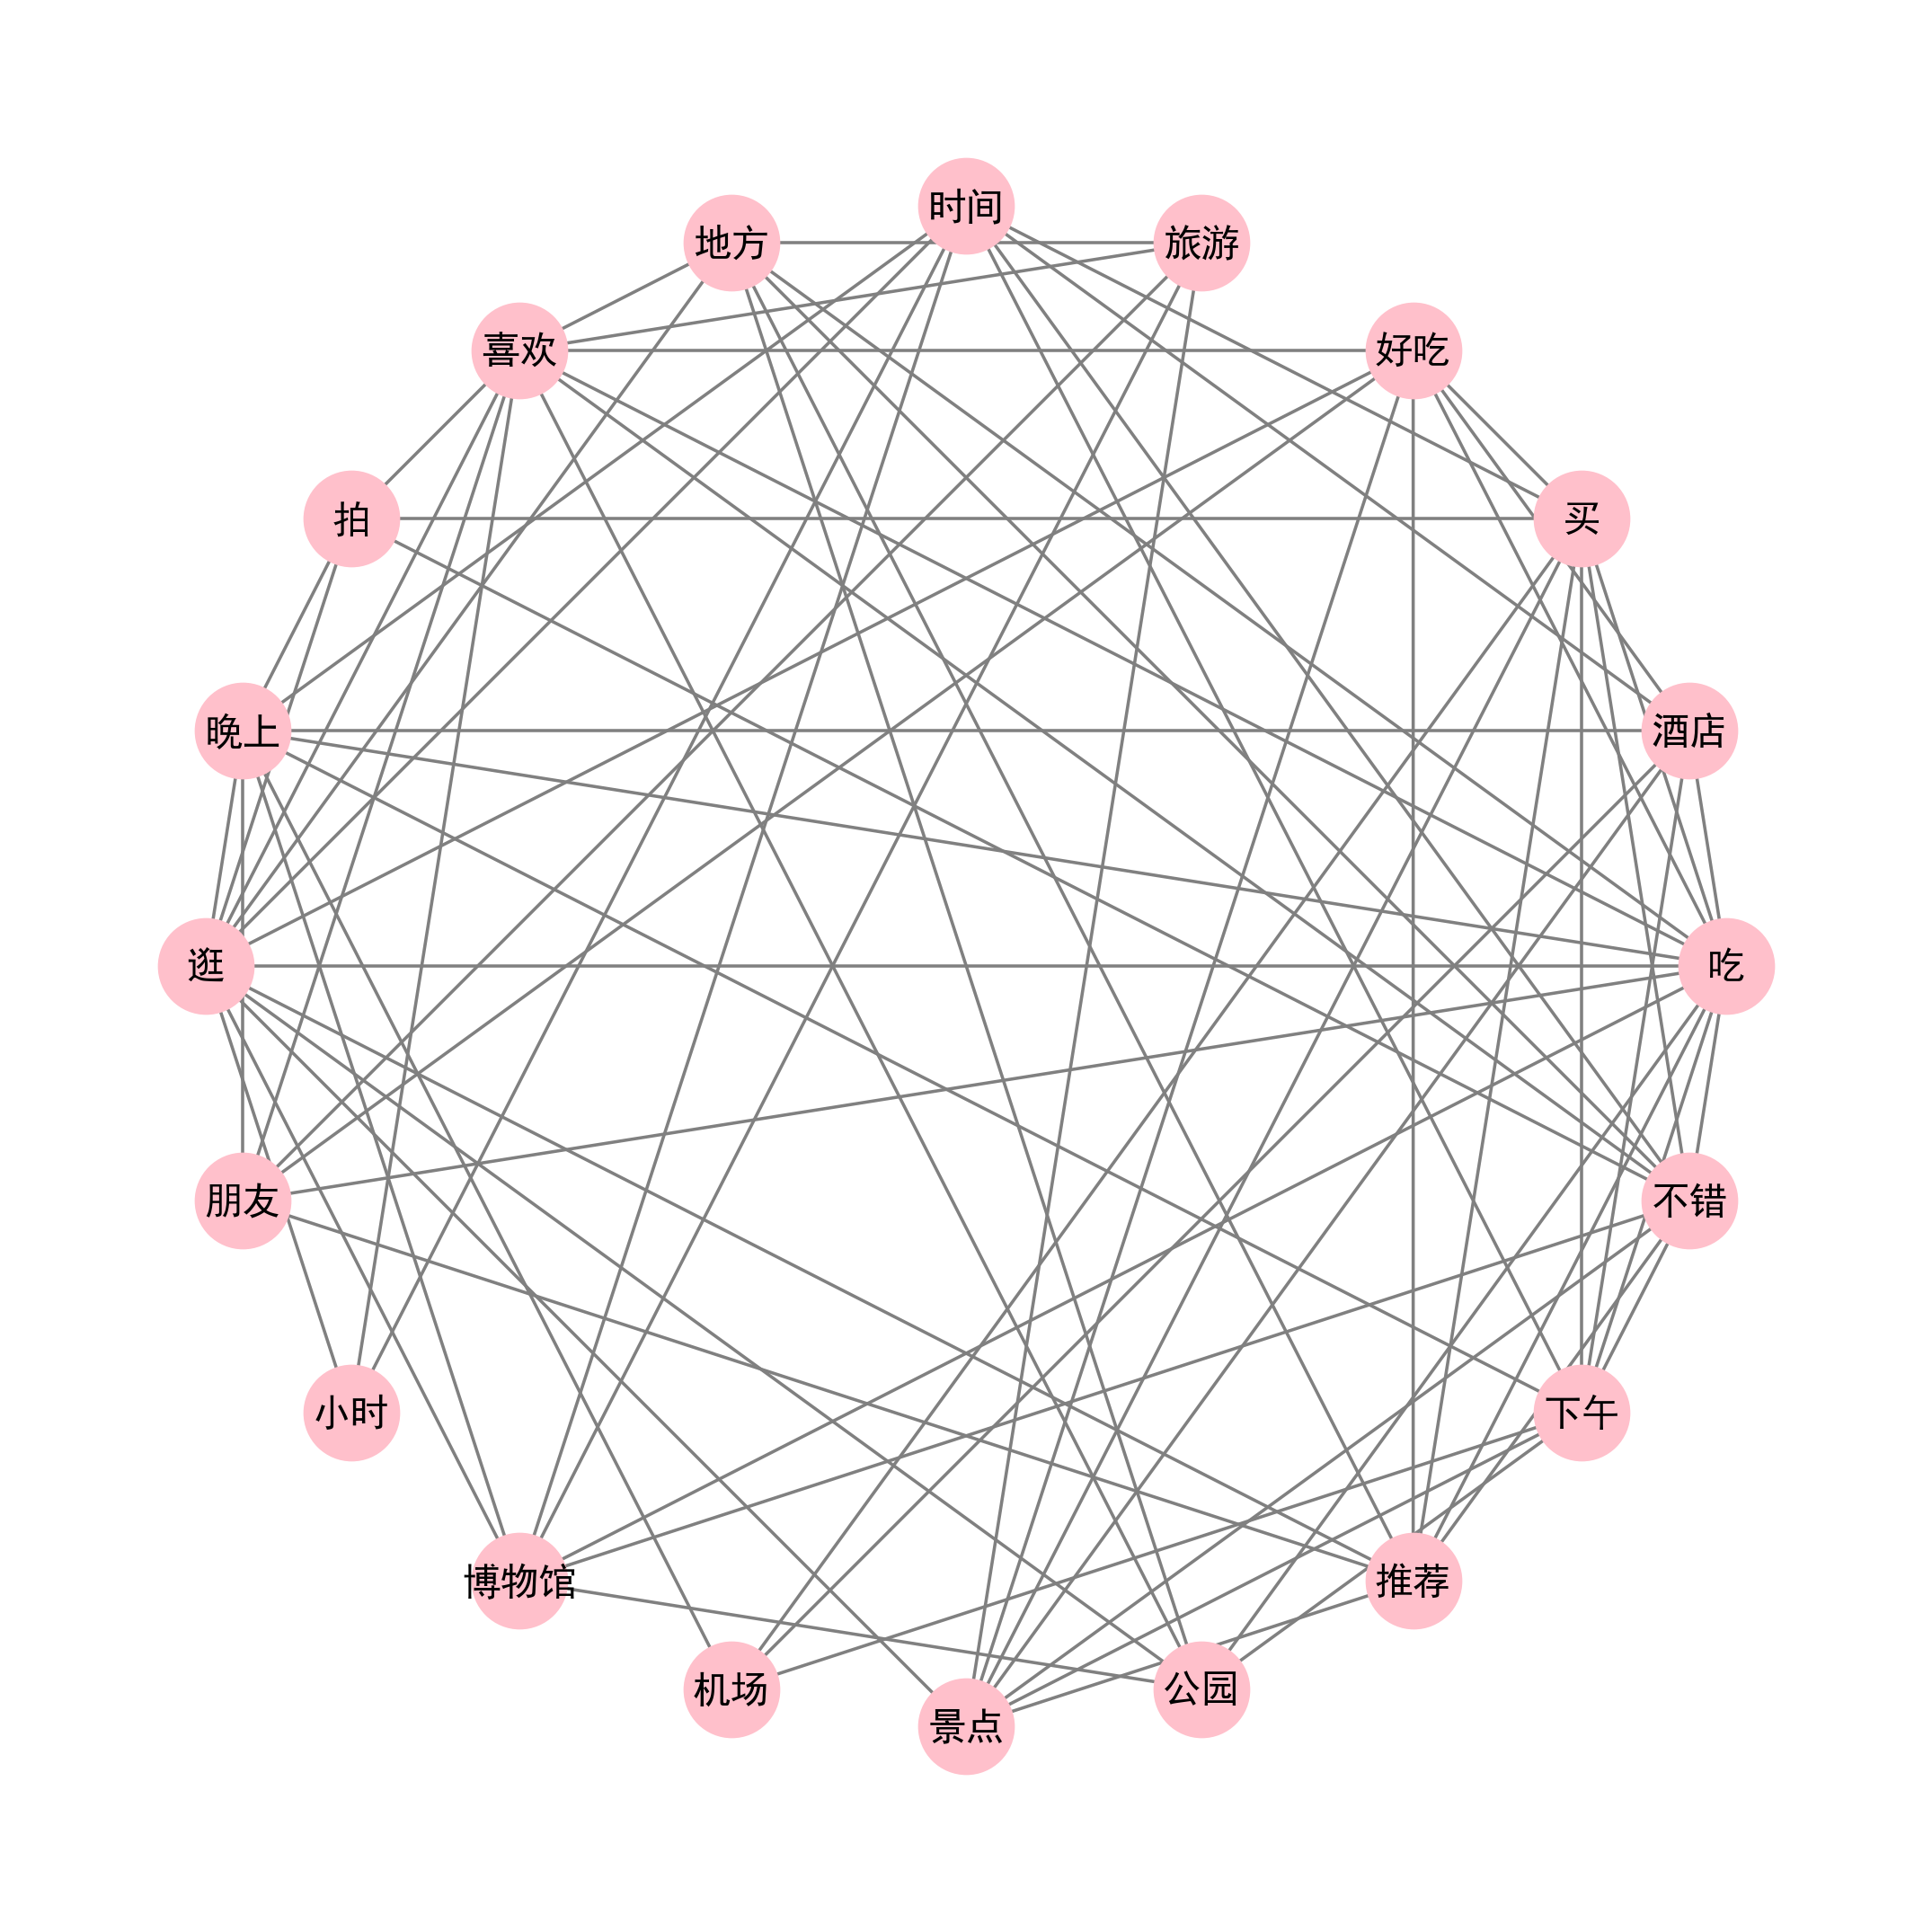

In [83]:
# 创建图形，设置大小、分辨率
plt.figure(figsize=(4, 4),dpi=512)
# 利用networkx库中from_pandas_adjacency函数创建无向图
graph1 = nx.from_pandas_adjacency(good_kwdata_)
# 圆形布局
pos = nx.circular_layout(graph1)
# 设置参数
nx.draw(graph1, 
        pos=pos,
        with_labels=True, #带标签
        node_color='pink', #节点颜色
        font_size=6, #字体大小
        font_family='SimHei', #黑体
        edge_color="grey", #边颜色
        width=0.5,#边宽度
        node_size=200,#节点大小
        node_shape='o')#节点形状

plt.show()

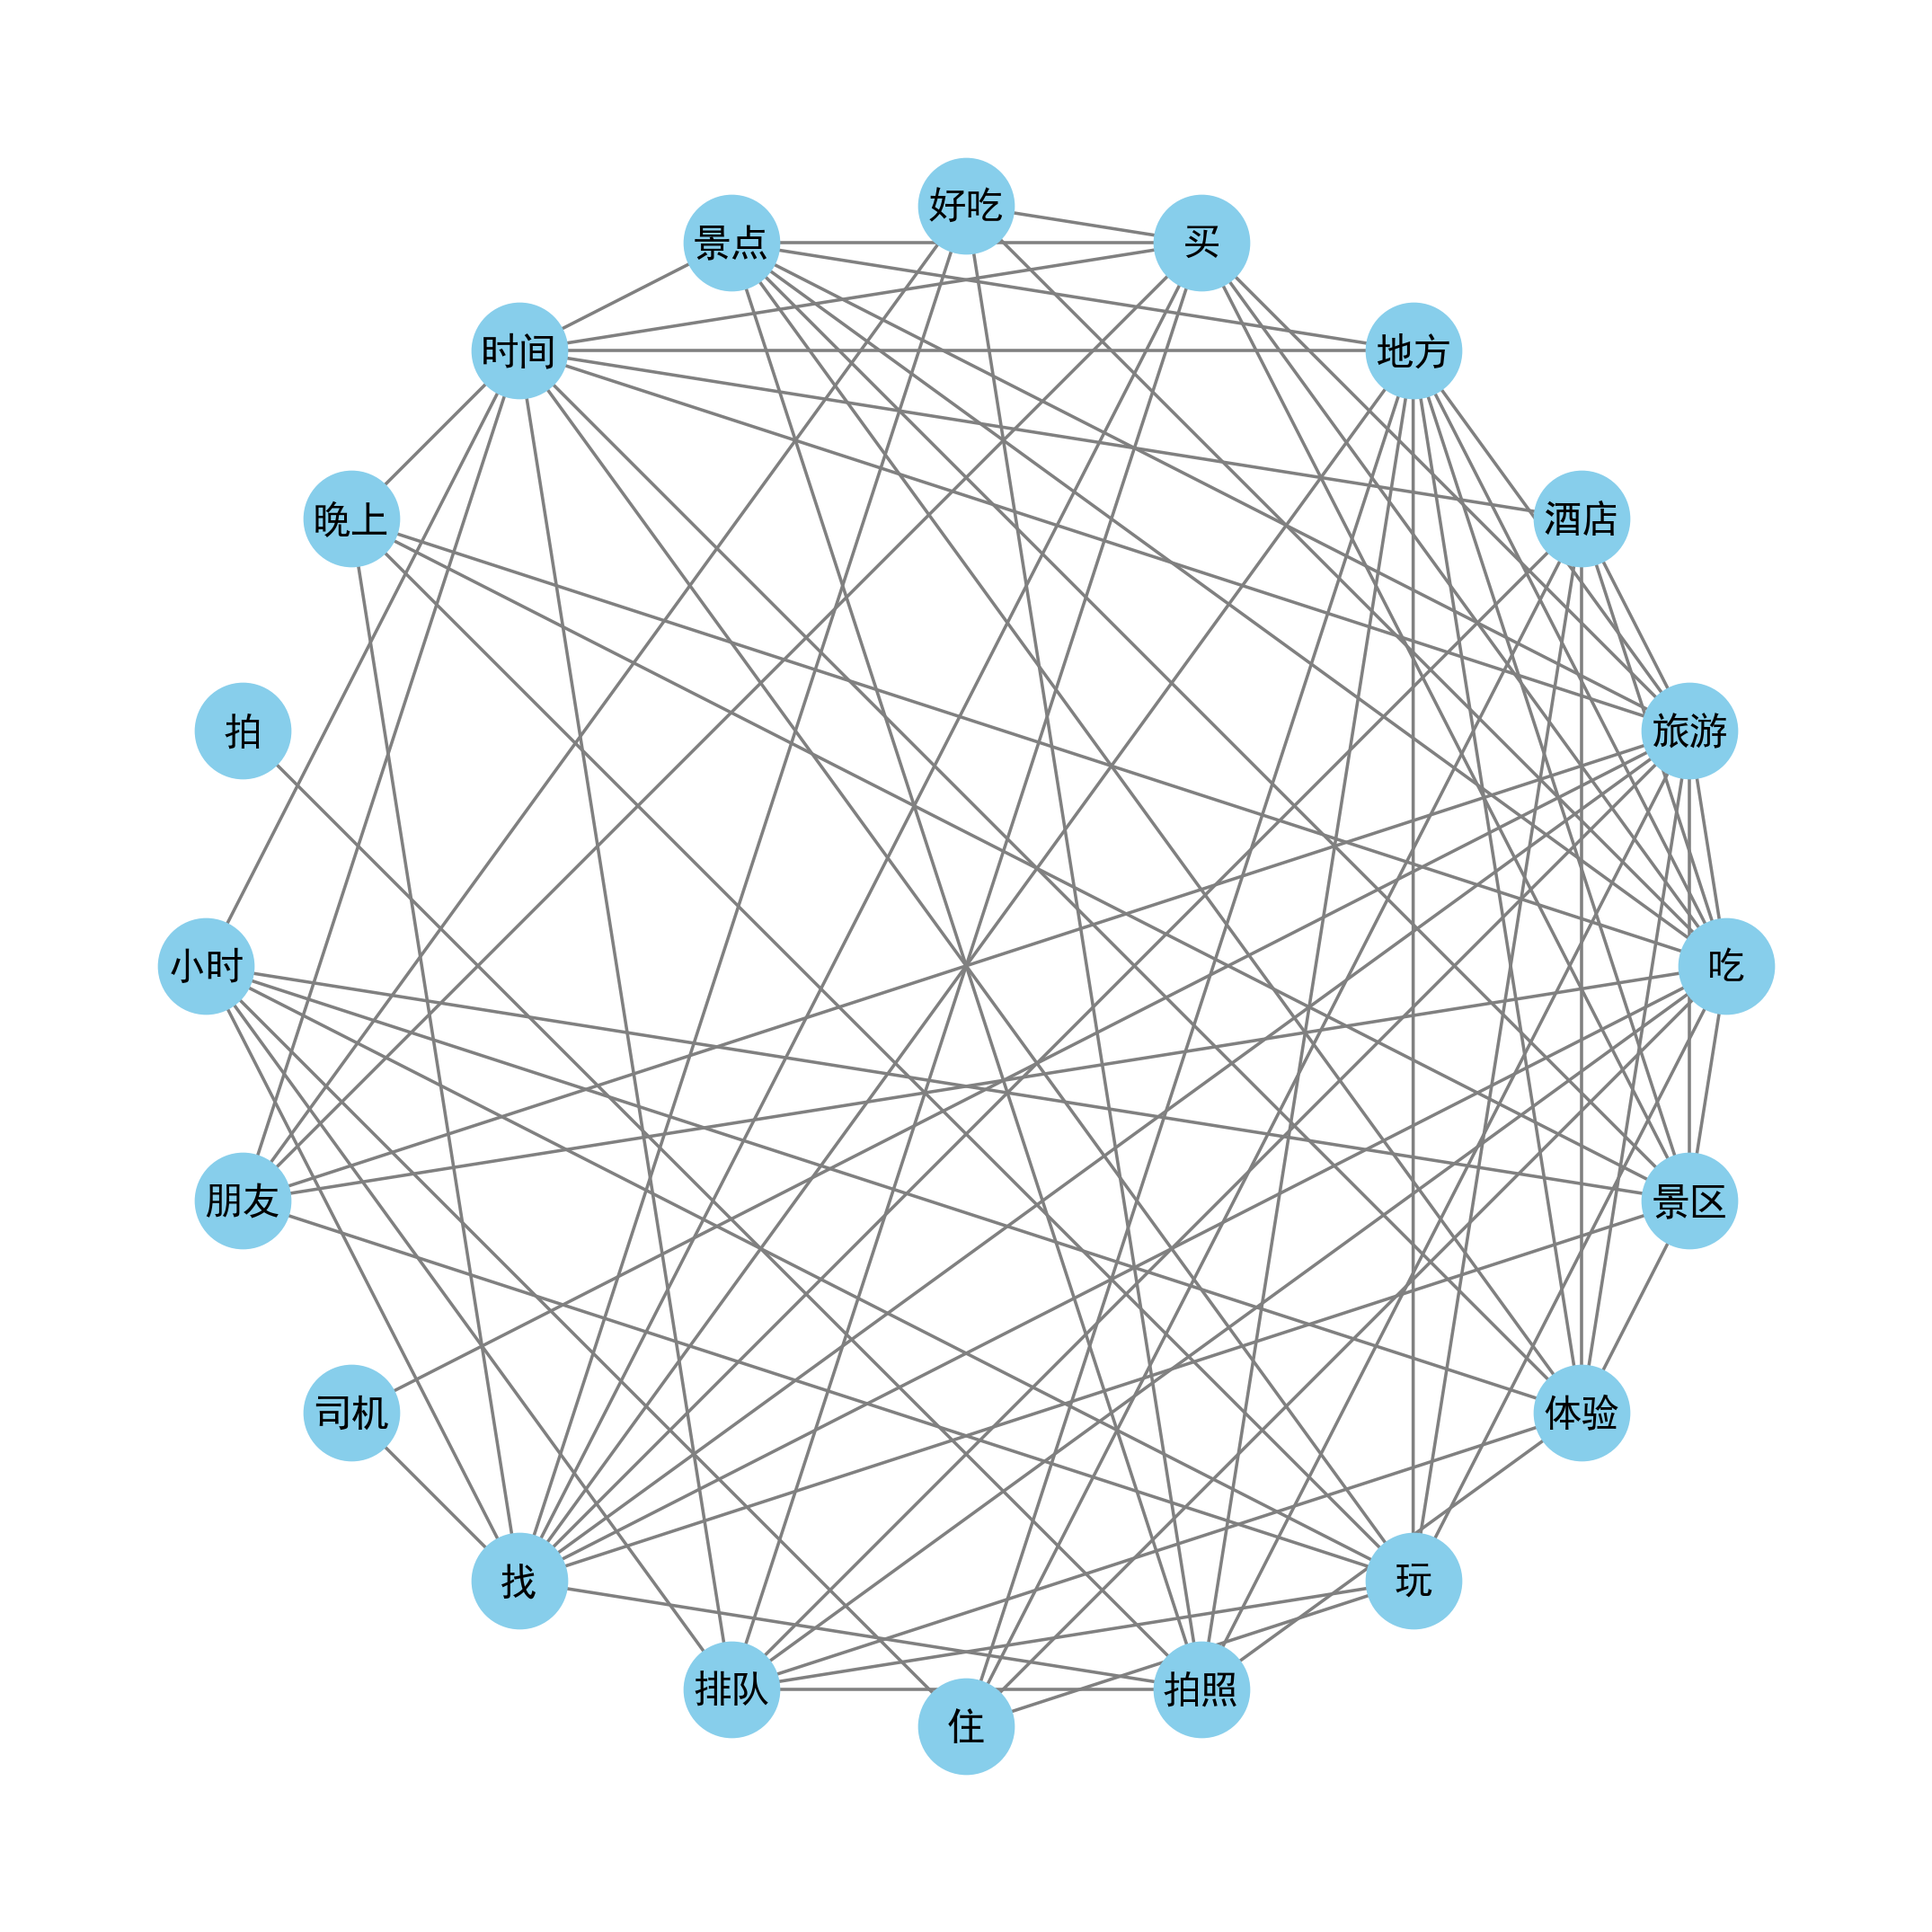

In [84]:
# 代码含义同上旅游成功小组
plt.figure(figsize=(4, 4),dpi=512)
graph2 = nx.from_pandas_adjacency(bad_kwdata_)

pos = nx.circular_layout(graph2)

nx.draw(graph2,
        pos=pos,
        with_labels=True,
        node_color='skyblue',
        font_size=6,
        font_family='SimHei',
        edge_color="grey",
        width=0.5,
        node_size=200,
        node_shape='o')

plt.show()

# Tf-idf分析，词频逆文档频率

In [85]:
from sklearn.feature_extraction.text import  CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [86]:
# 此处是旅游失败小组运行结果，旅游成功小组运行代码在注释中
# 将文本转化为词向量

#创建一个类实例
tf_vectorizer = TfidfVectorizer()

#对输入的文本集合 baddata.cutword 进行拟合（fit），然后将其转换（transform）为 TF-IDF 特征表示
bad_X = tf_vectorizer.fit_transform(baddata.cutword)
# good_X = tf_vectorizer.fit_transform(baddata.cutword)

print(bad_X.shape)
#print(good_X.shape)

(500, 25046)


In [87]:
# 查看高频词及tf-idf值
data1 = {'word': tf_vectorizer.get_feature_names_out(),
        'tfidf': bad_X.toarray().sum(axis=0).tolist()}
df2 = pd.DataFrame(data1).sort_values(by="tfidf" ,ascending=False,ignore_index=True) 
df2.head(20)

#data1 = {'word': tf_vectorizer.get_feature_names_out(),
#        'tfidf': goodd_X.toarray().sum(axis=0).tolist()}
#df2 = pd.DataFrame(data1).sort_values(by="tfidf" ,ascending=False,ignore_index=True) 
#df2.head(20)

,word,tfidf
0,旅游,13.994198
1,酒店,12.835159
2,地方,9.942460
3,景点,9.029211
4,好吃,8.576625
5,朋友,8.501000
6,司机,8.174096
7,晚上,7.258154
8,排队,7.024822
9,时间,6.799815


# LDA建模

In [88]:
# 设置主题数（经过困惑度计算后确认）
bad_n_topics = 2
bad_lda = LatentDirichletAllocation(n_components=bad_n_topics, max_iter=100,
                                learning_method='batch',
                                learning_offset=50,
                                random_state=0)
bad_lda.fit(bad_X)

#good_n_topics = 2
#good_lda = LatentDirichletAllocation(n_components=bad_n_topics, max_iter=100,
#                                learning_method='batch',
#                                learning_offset=50,
#                                random_state=0)
#goodd_lda.fit(goodd_X)

LatentDirichletAllocation(learning_offset=50, max_iter=100, n_components=2,
                          random_state=0)

In [89]:
# 定义函数
def print_top_words(model, feature_names, n_top_words):
    tword = []
    tword2 = []
    tword3=[] #存储主题关键词、权重字符串和关键词与权重的字典
    # 遍历每个主题
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        topic_w = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_pro=[str(round(topic[i],3)) for i in topic.argsort()[:-n_top_words - 1:-1]]  #(round(topic[i],3))
        tword.append(topic_w) 
        tword2.append(topic_pro)
        print(" ".join(topic_w))
        print(" ".join(topic_pro))
        print(' ')
        word_pro=dict(zip(topic_w,topic_pro))
        tword3.append(word_pro)
    return tword3 #返回了一个列表，每个元素是一个字典，代表每个主题中关键词和对应的权重

In [90]:
n_top_words = 10 #十个词
feature_names = tf_vectorizer.get_feature_names_out() #获取了文本向量化后的特征名称列表feature_names
word_pro = print_top_words(bad_lda, feature_names, n_top_words) # 调用函数

#n_top_words = 10
#feature_names = tf_vectorizer.get_feature_names_out()
#word_pro = print_top_words(good_lda, feature_names, n_top_words)

Topic #0:
旅游 酒店 地方 景点 好吃 朋友 司机 晚上 排队 时间
14.486 13.331 10.438 9.525 9.073 8.991 8.67 7.754 7.521 7.296
 
Topic #1:
开阔 捞饭 主意 海肠 功夫 九溪 协商 對象 破冰 视野
1.369 1.195 1.169 1.16 1.062 1.06 1.055 1.042 1.001 0.938
 
